In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pmdarima as pm
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from prophet import Prophet
from darts import TimeSeries
from darts.metrics.metrics import mape as mape1
from darts.metrics.metrics import mae as mae1
from darts.metrics.metrics import mse as mse1
from darts.models.forecasting.exponential_smoothing import ExponentialSmoothing
from darts.models.forecasting.theta import FourTheta
from darts.models.forecasting.fft import FFT
from darts.models.forecasting.random_forest import RandomForest

Importing plotly failed. Interactive plots will not work.


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
df = pd.read_csv('Electric_Production.csv', parse_dates=["DATE"])

In [4]:
df.head()

,DATE,IPG2211A2N
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DATE        397 non-null    datetime64[ns]
 1   IPG2211A2N  397 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.3 KB


In [6]:
df.shape

(397, 2)

In [7]:
df = df.rename(columns={'IPG2211A2N':'V1'})

In [8]:
print(df['DATE'].min())
print(df['DATE'].max())

1985-01-01 00:00:00
2018-01-01 00:00:00


In [9]:
df = df.set_index('DATE')

<AxesSubplot:xlabel='DATE', ylabel='V1'>

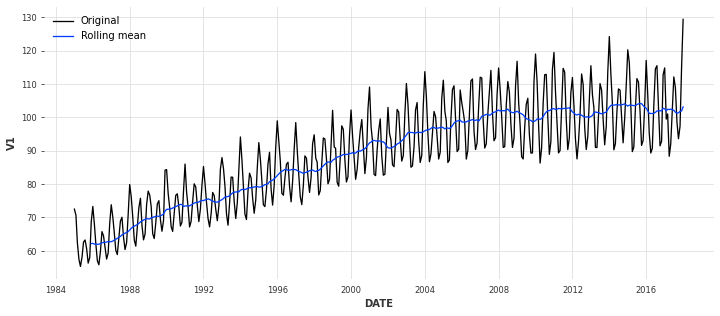

In [10]:
df['rolling_avg'] = df.rolling(12).mean()
plt.figure(figsize = (12, 5))
sns.lineplot(x='DATE', y='V1', data=df, label='Original')
sns.lineplot(x='DATE', y='rolling_avg', data=df, label='Rolling mean')

### Checking stationarity

In [11]:
# Augmented Dickey-Fuller test. ADF
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [12]:
df.drop('rolling_avg', axis=1, inplace=True)

In [13]:
# Seasonal decomposition
season_decomp = seasonal_decompose(df)

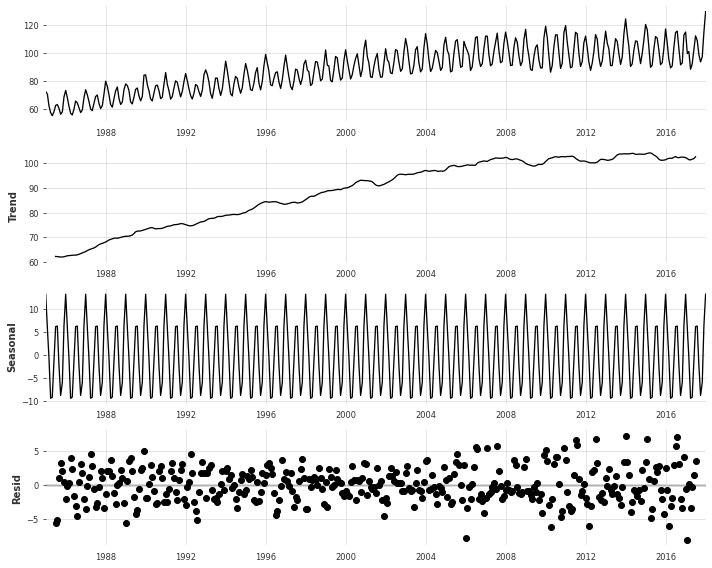

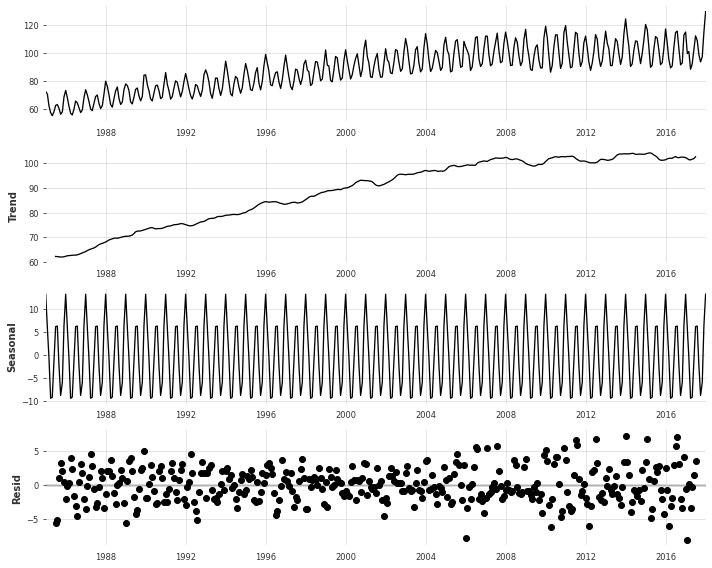

In [14]:
# Seasonal decomposition plot
rcParams['figure.figsize']=10,8
season_decomp.plot()

In [15]:
Augmented_Dickey_Fuller_Test_func(df,'V1')

Results of Dickey-Fuller Test for column: V1
Test Statistic                  -2.256990
p-value                          0.186215
No Lags Used                    15.000000
Number of Observations Used    381.000000
Critical Value (1%)             -3.447631
Critical Value (5%)             -2.869156
Critical Value (10%)            -2.570827
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


### Converting data to stationary

In [16]:
# The p-value is higher than 0.05 so the time serie is non stationary. Take difference.
df_diff = df.diff().dropna()

In [17]:
# After first order differencing, the series becomes stationary
Augmented_Dickey_Fuller_Test_func(df_diff,'V1')

Results of Dickey-Fuller Test for column: V1
Test Statistic                -7.104891e+00
p-value                        4.077787e-10
No Lags Used                   1.400000e+01
Number of Observations Used    3.810000e+02
Critical Value (1%)           -3.447631e+00
Critical Value (5%)           -2.869156e+00
Critical Value (10%)          -2.570827e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


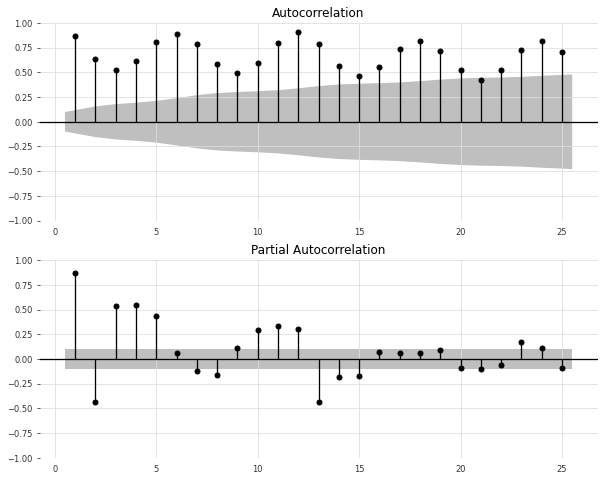

In [18]:
# ACF and PACF
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,8))
# Make ACF plot
plot_acf(df['V1'], lags=25, zero=False, ax=ax1)
# Make PACF plot
plot_pacf(df['V1'], lags=25, zero=False, ax=ax2)
plt.show()

### ARIMA

In [19]:
model_auto = pm.auto_arima(df, d=1, start_p=1, start_q=1, max_p=3, max_q=3, seasonal=True, m=6, D=1, start_P=1, 
                           start_Q=1, max_P=2, max_Q=2, information_criterion='aic', trace=True, error_action='ignore', 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=1912.925, Time=0.33 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=2404.500, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=1998.731, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=2057.803, Time=0.14 sec
 ARIMA(1,1,1)(0,1,1)[6]             : AIC=2000.250, Time=0.25 sec
 ARIMA(1,1,1)(1,1,0)[6]             : AIC=inf, Time=0.26 sec
 ARIMA(1,1,1)(2,1,1)[6]             : AIC=1880.044, Time=0.48 sec
 ARIMA(1,1,1)(2,1,0)[6]             : AIC=inf, Time=0.35 sec
 ARIMA(1,1,1)(2,1,2)[6]             : AIC=inf, Time=1.04 sec
 ARIMA(1,1,1)(1,1,2)[6]             : AIC=inf, Time=0.75 sec
 ARIMA(0,1,1)(2,1,1)[6]             : AIC=1925.181, Time=0.30 sec
 ARIMA(1,1,0)(2,1,1)[6]             : AIC=1942.791, Time=0.27 sec
 ARIMA(2,1,1)(2,1,1)[6]             : AIC=1881.313, Time=0.73 sec
 ARIMA(1,1,2)(2,1,1)[6]             : AIC=1880.682, Time=0.60 sec
 ARIMA(0,1,0)(2,1,1)[6]             : AIC=1955.485, T

In [20]:
# best model
model=SARIMAX(df, order=(2,1,2), seasonal_order=(1, 1, 2, 6))

In [21]:
results=model.fit()

In [22]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                V1   No. Observations:                  397
Model:             SARIMAX(2, 1, 2)x(1, 1, 2, 6)   Log Likelihood                -899.089
Date:                           Tue, 22 Mar 2022   AIC                           1814.177
Time:                                   17:39:58   BIC                           1845.907
Sample:                               01-01-1985   HQIC                          1826.755
                                    - 01-01-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0873      0.350     -0.249      0.803      -0.773       0.599
ar.L2          0.2828      0.214      1.321      0.187      -0.137       0.702
ma.L1         -0.2982      0.337     -0.884      0.377      -0.960       0.363
ma.L2         -0.6397      0.329     -1.944      0.052      -1.285       0.005
ar.S.L6       -0.9976      0.003   -380.160      0.000      -1.003      -0.992
ma.S.L6        0.1145      0.040      2.832      0.005       0.035       0.194
ma.S.L12      -0.7764      0.037    -20.853      0.000      -0.849      -0.703
sigma2         5.5549      0.307     18.092      0.000       4.953       6.157
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                42.26
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               2.75   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

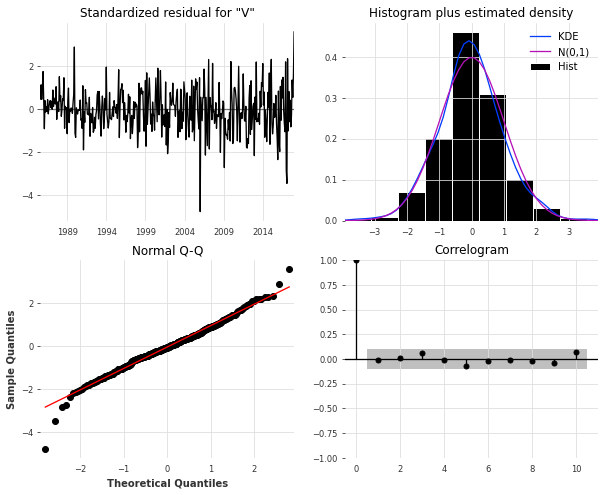

In [23]:
results.plot_diagnostics(figsize=(10,8))
plt.show()

In [24]:
forecast = results.get_prediction(start=-25)

In [25]:
mean_forecast = forecast.predicted_mean

In [26]:
# Get confidence intervals of  predictions
confidence_intervals = forecast.conf_int()

In [27]:
# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower V1']
upper_limits = confidence_intervals.loc[:,'upper V1']

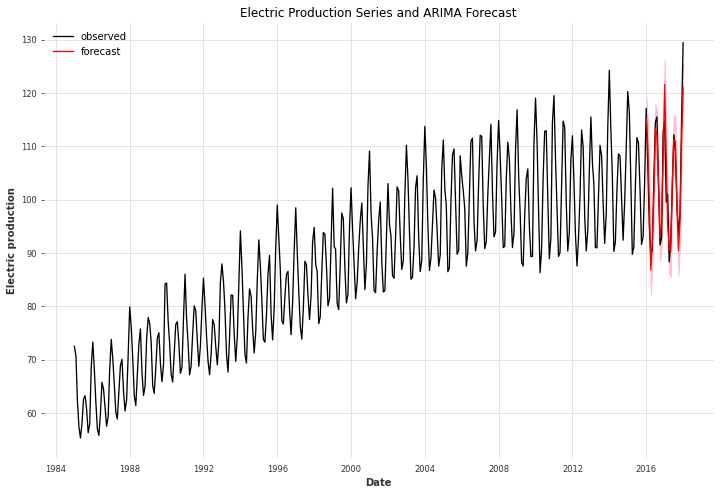

In [28]:
# plot data
plt.figure(figsize = (12, 8))
plt.plot(df.index, df, label='observed')

# plot mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

# set labels, legends and show plot
plt.title('Electric Production Series and ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Electric production')
plt.legend()
plt.show()

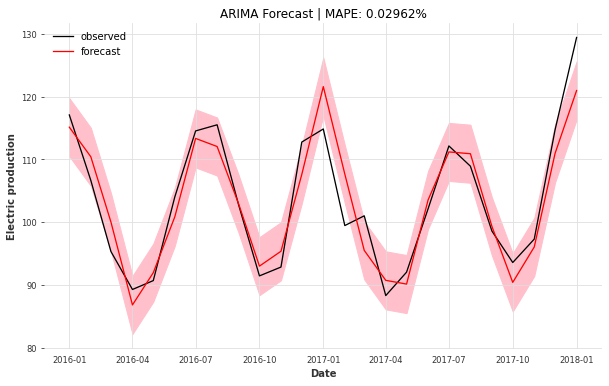

In [29]:
# plot data
plt.figure(figsize = (10, 6))
plt.plot(df[-25:].index, df[-25:].values, label='observed')

# plot mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

# set labels, legends and show plot
plt.title('ARIMA Forecast' + ' | MAPE: {:.5f}%'.format(mape(df.iloc[-25:,0], mean_forecast)))
plt.xlabel('Date')
plt.ylabel('Electric production')
plt.legend()
plt.show()

In [30]:
print(f"MAPE : {mape(df.iloc[-25:,0], mean_forecast):.5f} %")
print(f"MAE : {mae(df.iloc[-25:,0], mean_forecast):.5f} %")
print(f"MSE : {mse(df.iloc[-25:,0], mean_forecast):.5f} %")

MAPE : 0.02962 %
MAE : 3.10979 %
MSE : 14.50429 %


### Prophet

In [31]:
# default parameters
m = Prophet()

In [32]:
df2 = pd.read_csv('Electric_Production.csv', parse_dates=["DATE"])

In [33]:
df2 = df2.set_index('DATE')

In [34]:
# train test split
train2=df2.loc[:'2015']
test2=df2.loc['2016':]

In [35]:
train2.reset_index(inplace=True)

In [36]:
# DataFrame must have a specific format.
train2 = train2.rename(columns = {'DATE':'ds', 'IPG2211A2N':'y'})

In [37]:
m.fit(train2)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [38]:
# freq=MS, calendar month begin
future = m.make_future_dataframe(periods=25, freq='MS')

In [39]:
forecast = m.predict(future.iloc[-25:])

In [40]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
20,2017-09-01,101.101469,97.771510,104.639684
21,2017-10-01,95.030255,91.651058,98.561718
22,2017-11-01,97.952271,94.326458,101.484251
23,2017-12-01,110.337547,106.782211,114.006035
24,2018-01-01,116.793298,113.425719,120.159473


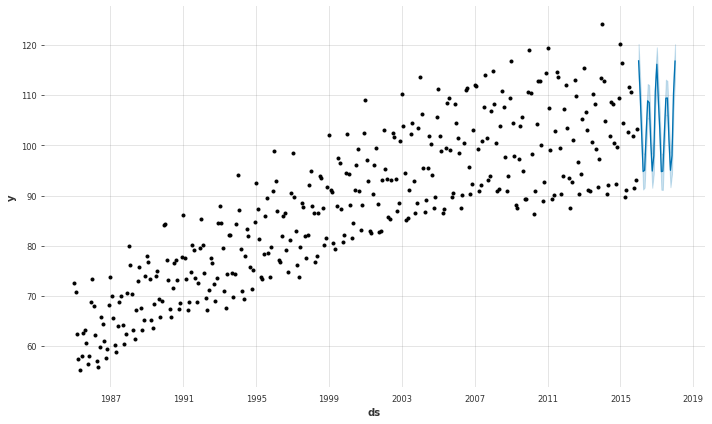

In [41]:
fig1 = m.plot(forecast)

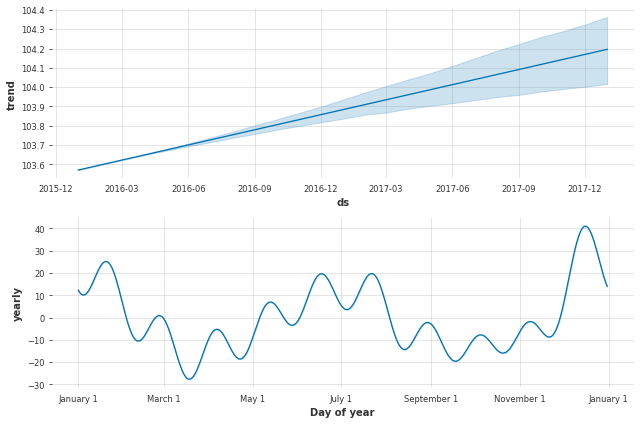

In [42]:
fig2 = m.plot_components(forecast)

In [43]:
y_true = df['V1'][-25:].values
y_pred = forecast['yhat'].values

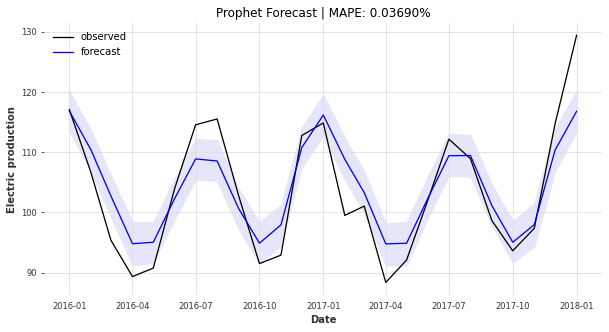

In [44]:
# plot data
plt.figure(figsize = (10, 5))
plt.plot(df[-25:].index, df[-25:].values, label='observed')

# plot mean predictions
plt.plot(forecast['ds'].iloc[-25:].values, forecast['yhat'].values, color='b', label='forecast')

# shade the area between confidence limits
plt.fill_between(forecast['ds'].iloc[-25:].values, forecast['yhat_lower'], forecast['yhat_upper'], color='lavender')

# set labels, legends and show plot
plt.title('Prophet Forecast' + ' | MAPE: {:.5f}%'.format(mape(y_true, y_pred)))
plt.xlabel('Date')
plt.ylabel('Electric production')
plt.legend()
plt.show()

In [45]:
# MAE RMSE
print(f"MAPE : {mape(y_true, y_pred):.5f} %")
print(f"MAE : {mae(y_true, y_pred):.5f} %")
print(f"MSE : {mse(y_true, y_pred):.5f} %")

MAPE : 0.03690 %
MAE : 3.80274 %
MSE : 23.30045 %


#### Tune PROPHET

In [46]:
### Tune prophet
m2 = Prophet(weekly_seasonality=False)
m2.add_seasonality(name='semi-annually', period=182.5, fourier_order=5)
forecast2 = m2.fit(train2).predict(future.iloc[-25:])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [48]:
y_pred2 = forecast2['yhat'].values

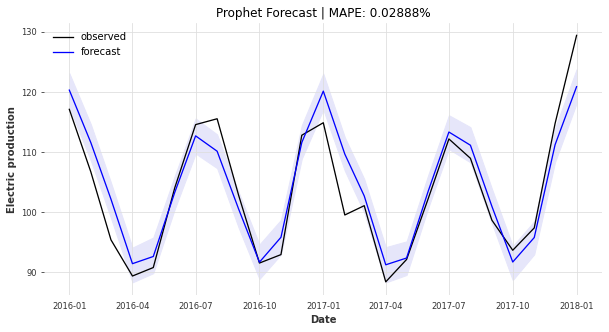

In [49]:
# plot data
plt.figure(figsize = (10, 5))
plt.plot(df[-25:].index, df[-25:].values, label='observed')

# plot mean predictions
plt.plot(forecast2['ds'].iloc[-25:].values, forecast2['yhat'].values, color='b', label='forecast')

# shade the area between confidence limits
plt.fill_between(forecast2['ds'].iloc[-25:].values, forecast2['yhat_lower'], forecast2['yhat_upper'], color='lavender')

# set labels, legends and show plot
plt.title('Prophet Forecast' + ' | MAPE: {:.5f}%'.format(mape(y_true, y_pred2)))
plt.xlabel('Date')
plt.ylabel('Electric production')
plt.legend()
plt.show()

In [50]:
print(f"MAPE : {mape(y_true, y_pred2):.5f} %")
print(f"MAE : {mae(y_true, y_pred2):.5f} %")
print(f"MSE : {mse(y_true, y_pred2):.5f} %")

MAPE : 0.02888 %
MAE : 3.03735 %
MSE : 15.28046 %


### DARTS

In [51]:
df1 = pd.read_csv('Electric_Production.csv', parse_dates=["DATE"])

In [52]:
df1 = df1.rename(columns={'IPG2211A2N':'V1'})

In [53]:
# TimeSeries is the main data class in Darts.
series = TimeSeries.from_dataframe(df1, 'DATE', 'V1')

In [55]:
train, val = series.split_after(pd.Timestamp('2015-12-01'))

In [56]:
# Evaluation function. Fit, predict, evaluate and plot.
def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print(model.__class__.__name__ + ' obtains: MAPE: {:.2f}% | MAE: {:.2f}% | MSE: {:.2f}%'.format(mape1(val, forecast), mae1(val, forecast), mse1(val, forecast)))
    plt.figure(figsize = (8, 4))
    val.plot(label='observed')
    forecast.plot(label='forecast', color='r')
    plt.title(model.__class__.__name__ + ' | MAPE: {:.2f}%'.format(mape1(val, forecast)))

#### Exponential Smoothing

ExponentialSmoothing obtains: MAPE: 3.22% | MAE: 3.47% | MSE: 23.71%


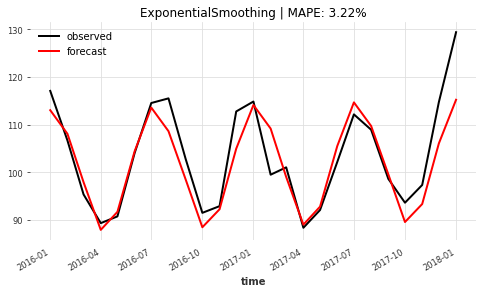

In [57]:
eval_model(ExponentialSmoothing(seasonal_periods=6))

#### Theta Method

FourTheta obtains: MAPE: 3.29% | MAE: 3.55% | MSE: 24.83%


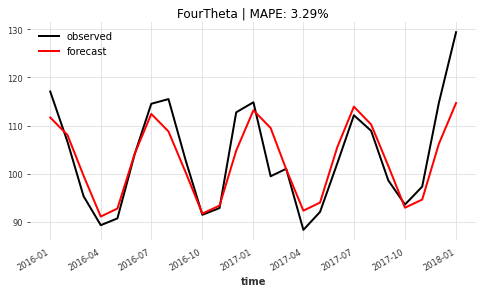

In [58]:
eval_model(FourTheta(seasonality_period=6, theta=20))

#### Fast Fourier Transform

FFT obtains: MAPE: 4.00% | MAE: 4.32% | MSE: 33.40%


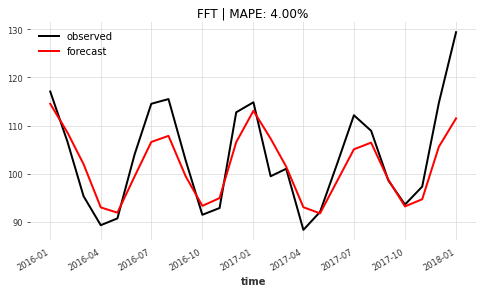

In [59]:
eval_model(FFT(nr_freqs_to_keep=16, trend='poly', trend_poly_degree=3))

#### Random Forest

RandomForest obtains: MAPE: 3.68% | MAE: 3.87% | MSE: 33.11%


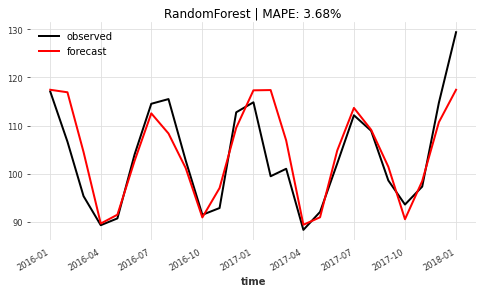

In [60]:
eval_model(RandomForest(lags=48, n_estimators=32))